In [6]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns
import numpy as np
from scipy import stats

In [7]:


# Load the dataset
file_path = 'dubizzle_cars_dataset.csv'
df = pd.read_csv(file_path,index_col=None)

# Display the first few rows of the dataset
# display(df.head())

# Display the summary of the dataset
# display(df.info())

# # Display the basic statistics of the dataset
# display(df.describe())

# # Check for missing values
# display(df.isnull().sum())

# # Display the columns of the dataset
# print(df.columns)

# # Display the data types of each column
# print(df['trim'].value_counts())


In [8]:
df=df.dropna(subset=['trim'])
df

,price,brand,model,trim,kilometers,year,vehicle_age_years,regional_specs,doors,body_type,...,interior_color,warranty,address,country,city,area_name,location_name,latitude,longitude,seller_type
0,129900,Dodge,Ram,1500 SLT Crew,47566,2021,3,GCC Specs,4,Pick Up Truck,...,Unknown,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
1,319900,Alfa Romeo,Stelvio,Quadrifoglio,8914,2020,4,GCC Specs,5,SUV,...,Black,Yes,"Abu Hail, Deira, Dubai, UAE",UAE,Dubai,Deira,Abu Hail,25.275416,55.346450,Dealership/Certified Pre-Owned
2,149900,Audi,Q5,S-line,72205,2019,5,GCC Specs,5,SUV,...,Brown,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
3,79900,Alfa Romeo,GIULIETTA,Veloce,49193,2021,3,GCC Specs,4,Hatchback,...,Black,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
4,154900,GAC,GS8,GL,30,2024,0,GCC Specs,5,SUV,...,Other Color,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,215000,Lexus,LX570,Platinum,191000,2016,8,GCC Specs,4,SUV,...,Beige,Does not apply,"Souq Al Haraj / Tasjeel Village, Saif Zone (Sh...",UAE,Sharjah,Saif Zone (Sharjah International Airport Free ...,Souq Al Haraj / Tasjeel Village,25.343567,55.473511,Dealer
9949,78000,Porsche,Cayenne,GTS,165000,2014,10,GCC Specs,4,SUV,...,Unknown,Does not apply,"Souq Al Haraj / Tasjeel Village, Saif Zone (Sh...",UAE,Sharjah,Saif Zone (Sharjah International Airport Free ...,Souq Al Haraj / Tasjeel Village,25.343567,55.473511,Dealer
9950,173000,Toyota,Land Cruiser,GXR,134000,2018,6,GCC Specs,4,SUV,...,Beige,Yes,"Souq Al Haraj / Tasjeel Village, Saif Zone (Sh...",UAE,Sharjah,Saif Zone (Sharjah International Airport Free ...,Souq Al Haraj / Tasjeel Village,25.343567,55.473511,Dealer
9951,63000,Toyota,Prado,Tx-l MID,290000,2011,13,GCC Specs,5,SUV,...,Beige,Does not apply,"Souq Al Haraj / Tasjeel Village, Saif Zone (Sh...",UAE,Sharjah,Saif Zone (Sharjah International Airport Free ...,Souq Al Haraj / Tasjeel Village,25.343567,55.473511,Dealer


In [9]:
# regional_specs,body_type,fuel_type,transmission_type,horsepower,warranty,seller_type,engine_capacity_cc

columns_to_remove = ['address', 'area_name', 'location_name', 'latitude', 'longitude','vehicle_age_years','country','interior_color','exterior_color','city','body_type','horsepower','engine_capacity_cc']
df_cleaned = df.drop(columns=columns_to_remove)
display(df_cleaned.head())

,price,brand,model,trim,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type
0,129900,Dodge,Ram,1500 SLT Crew,47566,2021,GCC Specs,4,Petrol,5,Automatic Transmission,8,Yes,Dealership/Certified Pre-Owned
1,319900,Alfa Romeo,Stelvio,Quadrifoglio,8914,2020,GCC Specs,5,Petrol,5,Automatic Transmission,6,Yes,Dealership/Certified Pre-Owned
2,149900,Audi,Q5,S-line,72205,2019,GCC Specs,5,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
3,79900,Alfa Romeo,GIULIETTA,Veloce,49193,2021,GCC Specs,4,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
4,154900,GAC,GS8,GL,30,2024,GCC Specs,5,Petrol,7,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned


In [24]:
brand_model_trim_dict = df.groupby(['brand', 'model'])['trim'].apply(list).to_dict()

# Initialize a dictionary to hold the final structure
brand_model_trim_dict_final = {}

# Populate the dictionary with the nested structure
for (brand, model), trims in brand_model_trim_dict.items():
    if brand not in brand_model_trim_dict_final:
        brand_model_trim_dict_final[brand] = {}
    # Remove duplicates and trim whitespace from trims
    trims = list(dict.fromkeys([trim.strip() for trim in trims if isinstance(trim, str)]))
    # Add the model with its trims
    brand_model_trim_dict_final[brand][model.strip()] = trims

# Display the dictionary to verify
print("\nBrand-Model-Trim Dictionary without duplicates and trimmed:")
print(brand_model_trim_dict_final['Nissan'])

import json
with open('brand_model_dict.json', 'w') as f:
    json.dump(brand_model_trim_dict_final, f)


Brand-Model-Trim Dictionary without duplicates and trimmed:
{'300ZX': ['Other'], '370z': ['Nismo'], 'Altima': ['SV', 'SL', 'S', 'Other', 'SR', 'SE'], 'Armada': ['SL', 'SE', 'Platinum', 'LE', 'SV', 'Titanium'], 'GT-R': ['Other'], 'Juke': ['Nismo', 'Other', 'S', 'SL', 'SV', 'SL Turbo'], 'Kicks': ['SV', 'Other', 'SL', 'S', 'SV Plus'], 'Maxima': ['Other', 'SE', 'SR', 'S', 'SL', 'SV'], 'Micra': ['SL', 'Other', 'SV', 'S'], 'Murano': ['LE', 'SL'], 'Navara': ['SE', 'CSPF', 'LE'], 'Pathfinder': ['SV', 'SL', 'S', 'SE', 'S 4WD', 'Platinum', 'LE', 'Other', 'XE'], 'Patrol': ['LE Platinum City', 'LE Titanium', 'SE P2', 'Other', 'XE', 'LE', 'Super Safari', 'LE Platinum', 'Basic', 'SE Platinum', 'Safari', 'Nismo', 'SE', 'SE P5', 'SE Platinum City', 'Safari AT', 'GL', 'LE Platinum + FES'], 'Pickup': ['Double Cab'], 'Qashqai': ['SE'], 'Quest': ['SV'], 'Rogue': ['Other', 'Standard'], 'Sentra': ['SV', 'S FE Plus', 'S', 'SL', 'SR', 'Other', 'SV Sport'], 'Sunny': ['SE', 'SV', 'S', 'Base', 'SL', 'SV Comfort

In [10]:
print("\nTypes of each column:")
display(df_cleaned.dtypes)


Types of each column:


price                 int64
brand                object
model                object
trim                 object
kilometers            int64
year                  int64
regional_specs       object
doors                 int64
fuel_type            object
seating_capacity      int64
transmission_type    object
no_of_cylinders       int64
warranty             object
seller_type          object
dtype: object

In [11]:
df_cleaned['brand'] = df_cleaned['brand'].str.strip().str.title()
df_cleaned['model'] = df_cleaned['model'].str.strip().str.title()
df_cleaned['trim'] = df_cleaned['trim'].str.strip().str.title()
df_cleaned['warranty'] = df_cleaned['warranty'].str.strip().str.title()
display(df_cleaned['warranty'].unique())
df_cleaned['regional_specs'] = df_cleaned['regional_specs'].str.strip().str.title()
df_cleaned['seller_type'] = df_cleaned['seller_type'].str.strip().str.title()

array(['Yes', 'No', 'Does Not Apply'], dtype=object)

In [12]:
columns_to_convert = [
    'brand','model','trim','regional_specs', 'fuel_type', 'transmission_type', 
    'warranty','seller_type'
]

# df_cleaned[columns_to_convert] = df_cleaned[columns_to_convert].fillna('Unknown')

categories = [
    'brand','model','trim','regional_specs', 'fuel_type', 'transmission_type', 
    'warranty', 'seller_type','no_of_cylinders','seating_capacity','doors'
]

# Convert the columns to categorical
for column in columns_to_convert:
    df_cleaned[column] = df_cleaned[column].str.strip().str.title()
    df_cleaned[column] = df_cleaned[column].astype('category')  

display(df_cleaned.dtypes)     

price                   int64
brand                category
model                category
trim                 category
kilometers              int64
year                    int64
regional_specs       category
doors                   int64
fuel_type            category
seating_capacity        int64
transmission_type    category
no_of_cylinders         int64
warranty             category
seller_type          category
dtype: object

In [13]:
df['warranty'].unique()

array(['Yes', 'No', 'Does not apply'], dtype=object)

In [14]:
# for column in columns_to_convert:
#     print(f"Categories for {column}:")
#     print(df_cleaned[column].cat.categories)

In [15]:
df_cleaned = df_cleaned.drop_duplicates()


In [16]:
df_cleaned.head()

,price,brand,model,trim,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type
0,129900,Dodge,Ram,1500 Slt Crew,47566,2021,Gcc Specs,4,Petrol,5,Automatic Transmission,8,Yes,Dealership/Certified Pre-Owned
1,319900,Alfa Romeo,Stelvio,Quadrifoglio,8914,2020,Gcc Specs,5,Petrol,5,Automatic Transmission,6,Yes,Dealership/Certified Pre-Owned
2,149900,Audi,Q5,S-Line,72205,2019,Gcc Specs,5,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
3,79900,Alfa Romeo,Giulietta,Veloce,49193,2021,Gcc Specs,4,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
4,154900,Gac,Gs8,Gl,30,2024,Gcc Specs,5,Petrol,7,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned


In [295]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# # Scatter plot of Price vs. Mileage
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='kilometers', y='price', data=df_cleaned)
# plt.title('Price vs. Mileage')
# plt.xlabel('Mileage')
# plt.ylabel('Price')
# plt.show()

# # Scatter plot of Price vs. Year
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='year', y='price', data=df_cleaned)
# plt.title('Price vs. Year')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.show()


# # Count plot of Car Brands
# plt.figure(figsize=(14, 16))
# sns.countplot(y='brand', data=df_cleaned, order=df_cleaned['brand'].value_counts().index)
# plt.title('Count of Cars by Brand')
# plt.xlabel('Count')
# plt.ylabel('Brand')
# plt.show()

# # Boxplot of Car Prices by Brand
# plt.figure(figsize=(14, 16))
# sns.boxplot(x='price', y='brand', data=df_cleaned)
# plt.title('Boxplot of Car Prices by Brand')
# plt.xlabel('Price')
# plt.ylabel('Brand')
# plt.show()

In [296]:
display(df_cleaned.dtypes)

price                   int64
brand                category
model                category
trim                 category
kilometers              int64
year                    int64
regional_specs       category
doors                   int64
fuel_type            category
seating_capacity        int64
transmission_type    category
no_of_cylinders         int64
warranty             category
seller_type          category
dtype: object

In [297]:
print("before encoding: ")
display(df_cleaned['seller_type'].unique())

before encoding: 


['Dealership/Certified Pre-Owned', 'Owner', 'Dealer']
Categories (3, object): ['Dealer', 'Dealership/Certified Pre-Owned', 'Owner']

In [298]:


# Ensure the columns are properly categorized
categorical_columns = [
    'brand','model','trim','regional_specs', 'fuel_type', 'transmission_type', 
    'warranty','seller_type','no_of_cylinders','seating_capacity','doors'
]

numerical_columns = ['kilometers', 'year']

label_encoders={}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

scaler_y = MinMaxScaler()
df_cleaned['price'] = scaler_y.fit_transform(df_cleaned['price'].values.reshape(-1, 1)).flatten() 

# Use OneHotEncoder for the rest of the categorical variables
# onehot_columns = [col for col in categorical_columns if col not in label_enc_columns]
# encoder = OneHotEncoder(sparse_output=False, drop='first')
# encoded_features = encoder.fit_transform(df_cleaned[onehot_columns])

# Create a DataFrame with the encoded features
# encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(onehot_columns))

# Ensure indices align before concatenation
# encoded_df.index = df_cleaned.index

# Concatenate the original DataFrame (excluding the original one-hot encoded columns) with the encoded DataFrame
# df_encoded = pd.concat([df_cleaned.drop(columns=onehot_columns), encoded_df], axis=1)


# Use StandardScaler to normalize numerical features
scaler_x = StandardScaler()
df_encoded=df_cleaned
df_encoded[numerical_columns] = scaler_x.fit_transform(df_encoded[numerical_columns])
# Serialize the scalers
joblib.dump(scaler_x, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

In [299]:
print('after encoding:')
display(df_encoded)

after encoding:


,price,brand,model,trim,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type
0,0.129042,21,466,25,-0.384713,0.568479,4,2,3,3,0,5,2,1
1,0.319251,2,529,542,-0.819964,0.369220,4,3,3,3,0,4,2,1
2,0.149064,4,446,589,-0.107259,0.169962,4,3,3,3,0,2,2,1
3,0.078987,2,254,742,-0.366392,0.568479,4,2,3,3,0,2,2,1
4,0.154069,27,284,343,-0.920004,1.166253,4,3,3,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,0.214236,50,365,520,1.230463,-0.427812,4,2,3,0,0,5,0,0
9949,0.077085,69,122,413,0.937683,-0.826328,4,2,3,3,0,5,0,0
9950,0.172189,83,353,420,0.588600,-0.029296,4,2,3,5,0,4,2,0
9951,0.062068,83,438,728,2.345278,-1.424102,4,3,3,5,0,4,0,0


In [300]:
df_encoded.shape[1]

14

In [301]:
# # Group by brand and model
# grouped = df_encoded.groupby(['brand', 'model','year'])

# def remove_outliers(group):
#     z_scores = np.abs(stats.zscore(group['price']))
#     threshold = 3
#     return group[z_scores <= threshold]

# # Apply the outlier removal function to each group
# df_no_outliers = grouped.apply(remove_outliers).reset_index(drop=True)

# # Check the shape of the data before and after removing outliers
# print(f"Original dataset shape: {df_cleaned.shape}")
# print(f"Dataset shape after removing outliers: {df_no_outliers.shape}")


In [302]:
df_encoded.head()

,price,brand,model,trim,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type
0,0.129042,21,466,25,-0.384713,0.568479,4,2,3,3,0,5,2,1
1,0.319251,2,529,542,-0.819964,0.369220,4,3,3,3,0,4,2,1
2,0.149064,4,446,589,-0.107259,0.169962,4,3,3,3,0,2,2,1
3,0.078987,2,254,742,-0.366392,0.568479,4,2,3,3,0,2,2,1
4,0.154069,27,284,343,-0.920004,1.166253,4,3,3,5,0,2,2,1


In [303]:

# Split the data into training and testing sets
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = xgb_model.predict(X_test)

joblib.dump(xgb_model,'xgb_model.pkl')

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)



print(f"\nXGBoost Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")




XGBoost Model Performance:
RMSE: 0.1101
R²: 0.6718
MAE: 0.0554


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [304]:
display(df_encoded.dtypes)

price                float64
brand                  int32
model                  int32
trim                   int32
kilometers           float64
year                 float64
regional_specs         int32
doors                  int64
fuel_type              int32
seating_capacity       int64
transmission_type      int32
no_of_cylinders        int64
warranty               int32
seller_type            int32
dtype: object

In [308]:
# Example test input
test_input = {
    'brand': ['Honda'],
    'model': ['Cr-V'],
    'trim': ['Ex Plus'],
    'kilometers': [155000],
    'year': [2015],
    'regional_specs': ['Gcc Specs'],
    'doors': ['4'],
    'fuel_type': ['Petrol'],
    'seating_capacity': ['5'],
    'transmission_type': ['Automatic Transmission'],
    'no_of_cylinders': ['4'],
    'warranty': ['Does Not Apply'],
    'seller_type': ['Owner'],
}

test_df = pd.DataFrame(test_input)

# Load scalers and encoders
scaler_x = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')
label_encoders = joblib.load('label_encoders.pkl')

# Apply label encoders
for col in categorical_columns:
    le = label_encoders[col]
    test_df[col] = le.transform(test_df[col])

# Apply standard scaler to numerical columns
test_df[numerical_columns] = scaler_x.transform(test_df[numerical_columns])

# Load the trained model
xgb_model = joblib.load('xgb_model.pkl')

# Make predictions
y_pred = xgb_model.predict(test_df)

# Inverse transform the predicted price to get the actual value
predicted_price = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"Predicted price: {predicted_price[0]:.2f}")


Predicted price: 28239.46


In [ ]:
# plt.subplot(1, 3, 3)
# plt.scatter(y_test, y_pred, alpha=0.3)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('XGBoost: Actual vs. Predicted')

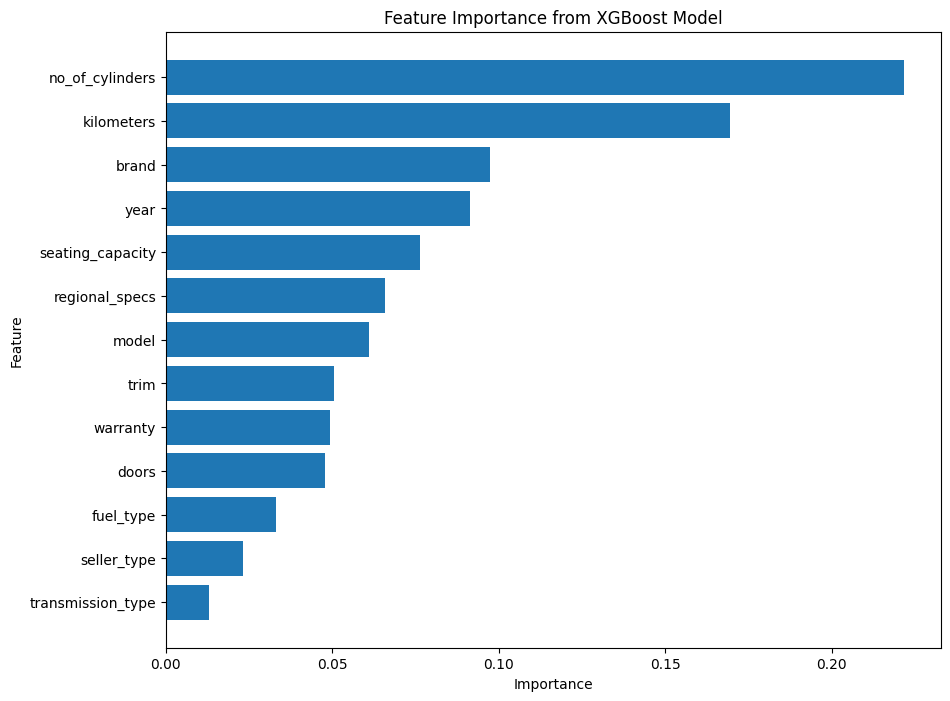

In [307]:
feature_importance = xgb_model.feature_importances_
features = df_encoded.drop(columns=['price']).columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Serialize the trained model
joblib.dump(xgb_model, 'xgb_model.pkl')



['xgb_model.pkl']

In [ ]:
# for col, encoder in label_encoders.items():
#     print(f"Column: {col}")
#     # print(f"Classes: {encoder.classes_}")
#     print()
print(label_encoders.items())

dict_items([('brand', LabelEncoder()), ('model', LabelEncoder()), ('trim', LabelEncoder()), ('regional_specs', LabelEncoder()), ('body_type', LabelEncoder()), ('fuel_type', LabelEncoder()), ('transmission_type', LabelEncoder()), ('engine_capacity_cc', LabelEncoder()), ('warranty', LabelEncoder()), ('seller_type', LabelEncoder()), ('exterior_color', LabelEncoder()), ('interior_color', LabelEncoder()), ('city', LabelEncoder()), ('no_of_cylinders', LabelEncoder()), ('seating_capacity', LabelEncoder()), ('doors', LabelEncoder()), ('horsepower', LabelEncoder())])


In [ ]:
display(df_no_outliers)

,price,brand,model,trim,kilometers,year,regional_specs,doors,body_type,fuel_type,seating_capacity,transmission_type,engine_capacity_cc,horsepower,no_of_cylinders,exterior_color,interior_color,warranty,city,seller_type
0,0.108119,0,50,512,-0.865646,0.952984,4,0,3,3,2,0,9,2,2,1,1,2,3,2
1,0.108119,0,50,512,-0.876920,0.952984,4,0,0,3,2,0,1,1,2,1,1,2,3,0
2,0.128141,0,50,512,-0.820549,0.952984,4,1,3,3,2,0,1,1,2,2,1,2,3,0
3,0.084093,2,255,753,0.378957,-0.042259,4,2,7,3,3,0,3,2,2,11,1,1,3,0
4,0.085995,2,255,753,-0.067061,-0.042259,4,2,7,3,3,0,3,2,2,11,3,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6197,0.009911,87,613,238,1.118612,-2.032744,4,2,6,3,5,0,4,2,4,7,0,1,3,2
6198,0.015918,87,613,678,2.110740,-2.032744,4,3,6,3,5,0,7,3,5,12,0,1,3,2
6199,0.159175,87,613,437,-0.239928,0.156790,4,2,6,3,5,0,3,3,2,7,3,0,3,2
6200,0.134148,87,613,541,-0.020081,0.156790,4,2,6,3,5,0,9,1,2,7,6,2,3,0
